In [1]:
#imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
def show_image(img,gray=0):    
    if gray == 1:
        plt.imshow(img, cmap='gray')        
    else:
        plt.imshow(img)    
    plt.show()

In [3]:
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from skimage.feature import hog
from sklearn.utils import shuffle

from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import ELU
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Lambda, Dropout
 
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
from keras.models import model_from_json
import simplejson as json
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import random
import math

### Make data frame in Pandas

import pandas as pd



Using TensorFlow backend.


In [77]:


def trans_image(image,image1,trans_range=150):
    # Translation augmentation
    
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2

    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    rows,cols,channels = image.shape
   
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    image_tr1 = cv2.warpAffine(image1,Trans_M,(cols,rows))
    return image_tr, image_tr1


def stretch_image(img,img1,scale_range=150):
    # Stretching augmentation 
    
    tr_x1 = scale_range*np.random.uniform()
    tr_y1 = scale_range*np.random.uniform()
    p1 = (tr_x1,tr_y1)
    tr_x2 = scale_range*np.random.uniform()
    tr_y2 = scale_range*np.random.uniform()
    p2 = (img.shape[1]-tr_x2,tr_y1)

    p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
    p4 = (tr_x1,img.shape[0]-tr_y2)

    pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
    pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],
                   [0,img.shape[0]] ]
                   )

    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
    img = np.array(img,dtype=np.uint8)
    
    img1 = cv2.warpPerspective(img1,M,(img1.shape[1],img1.shape[0]))
    img1 = np.array(img1,dtype=np.uint8)
    
    return img,img1

def CropImage(image):
    #Crops the iamge so that the hood of the car and top of the image
    #which contains sky trees and other stuffs are removed.
    height = len(image)
    return image[int(height * 1/5.):int(height * 6/7.0), :, :]


def RandomBrightness(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(img)

    scale = random.uniform(.5, 1.25)

    v = np.clip(v * scale, 0, 255, out=v)
    img = cv2.merge((h, s, v))
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

In [78]:
train_samples_per_epoch = 1500
trainBatchSize = 30
imgRow = 512
imgCol = 512
croppedImgRow = imgRow
croppedImgCol = imgCol
smooth = 1.



def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [79]:
def transform_image(img,img1,ang_range=30,shear_range=10,trans_range=5):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    #print("angle Rot: ",ang_rot)
    coin = np.random.randint(2)
    if coin == 0:
        coin = -1
    rows,cols,ch = img.shape    
    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),coin*ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    img = RandomBrightness(img)
    
    img1 = cv2.warpAffine(img1,Rot_M,(cols,rows))
    img1 = cv2.warpAffine(img1,Trans_M,(cols,rows))
    img1 = cv2.warpAffine(img1,shear_M,(cols,rows))

    return img,img1

In [80]:
def augmentImage(image1,image2):
    
    choice = np.random.randint(6)
    if choice == 0:
        return RandomBrightness(image1),image2
    elif choice == 1:
        return stretch_image(image1,image2)
    elif choice == 2:
        return trans_image(image1,image2)
    else:
        return transform_image(image1,image2)
    

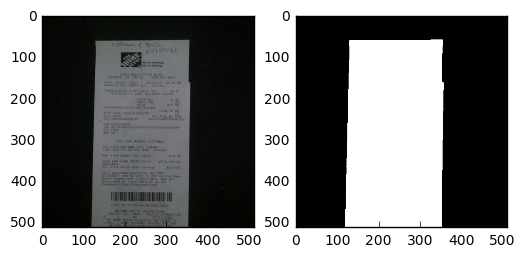

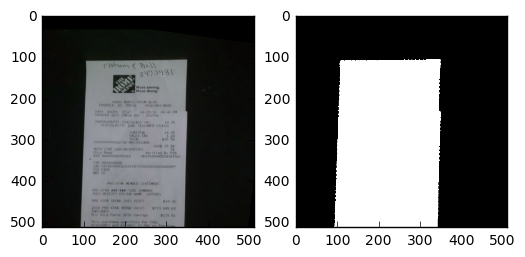

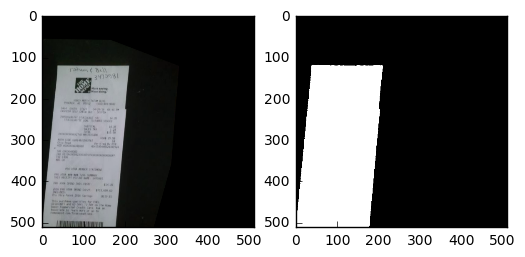

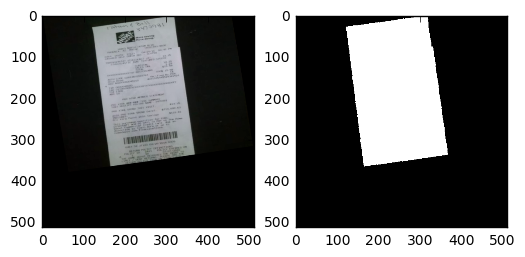

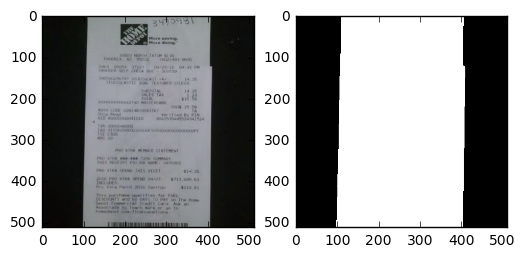

In [95]:
def TestAugmentation():
    images = glob.glob(".\images\*.jpg")
    i=0
    while i<5:
        indx = 5
        frame = "./images/"+str(indx)+".jpg"
        frame1 = "./images/"+str(indx)+".png"
        
        image = cv2.imread(frame)
        image1 = cv2.imread(frame1)
        
        image = cv2.resize(image, (imgCol,imgRow))
        image1 = cv2.resize(image1, (imgCol,imgRow))
        
        image, image1 = augmentImage(image,image1)
        
        targetImg = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.imshow(targetImg,cmap="gray")
        plt.show()
        
        i=i+1
TestAugmentation()

In [83]:
def TrainDataGenerator(batchSize):
    images = glob.glob(".\images\*.jpg")
    batch_x, batch_y = [], []
    while True:
        indx = np.random.randint(len(images)) + 1
        if(indx == 8):
            continue
        frame = "./images/"+str(indx)+".jpg"
        frame1 = "./images/"+str(indx)+".png"
        
        image = cv2.imread(frame)
        image1 = cv2.imread(frame1)
        
        image = cv2.resize(image, (imgCol,imgRow))
        image1 = cv2.resize(image1, (imgCol,imgRow))
        
        image,image1 = augmentImage(image,image1)
        
        targetImg = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        targetImg = np.reshape(targetImg, (imgRow,imgCol,1))
        
        batch_x.append(image)
        batch_y.append(targetImg)

        if len(batch_x) == batchSize:
            x_array = np.asarray(batch_x)
            y_array = np.asarray(batch_y)
            yield (x_array, y_array)
            batch_x, batch_y = [], []

In [85]:
def CreateModel():   
    
    input_layer = Input((imgRow, imgCol, 3))
    conv0 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(input_layer)
    conv0 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv0)
    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)

    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool0)
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same',W_regularizer=l2(.01))(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same',W_regularizer=l2(.01))(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same',W_regularizer=l2(.01))(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same',W_regularizer=l2(.01))(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv4_0 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool4)
    conv4_0 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4_0)

    up5_0 = merge([UpSampling2D(size=(2, 2))(conv4_0), conv4], mode='concat', concat_axis=3)
    conv5_0 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up5_0)
    conv5_0 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv5_0)

    up5 = merge([UpSampling2D(size=(2, 2))(conv5_0), conv3], mode='concat', concat_axis=3)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up5)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same',W_regularizer=l2(.01))(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv2], mode='concat', concat_axis=3)
    conv6 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(32, 3, 3, activation='relu', border_mode='same',W_regularizer=l2(.01))(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv1], mode='concat', concat_axis=3)
    conv7 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(16, 3, 3, activation='relu', border_mode='same',W_regularizer=l2(.01))(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv0], mode='concat', concat_axis=3)
    conv8 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv8)

    conv9 = Convolution2D(1, 1, 1, activation='sigmoid')(conv8)

    model = Model(input=input_layer, output=conv9)

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model




In [84]:

model = CreateModel()

trainGenerator = TrainDataGenerator( trainBatchSize)

weight_save_callback = ModelCheckpoint('./weights/weights.{epoch:02d}-{loss:.4f}.h5', monitor='loss', verbose=2,
                                       save_best_only=False, mode='auto')
model.summary()

model.load_weights('model.h5')

print("Created generator and call backs. Starting training")

model.fit_generator(
    trainGenerator,
    samples_per_epoch=train_samples_per_epoch, nb_epoch=10,
    # validation_data=validGenerator,
    # nb_val_samples=valid_samples_per_epoch,
    callbacks=[weight_save_callback],
    verbose=1
)

model.save_weights('model.h5', True)
with open('model.json', 'w') as file:
    json.dump(model.to_json(), file)

NameError: name 'CreateModel' is not defined

In [9]:
from keras.models import model_from_json

with open('model.json', 'r') as jfile:
    model = model_from_json(json.loads(jfile.read())) 
    print('model loaded')

model.compile(optimizer=Adam(lr=1e-4), loss="mse", metrics=['accuracy'])
weights_file = 'model.h5'
model.load_weights(weights_file)

model loaded


In [87]:
def floodFill(img):
    one = 0
    outputMask = np.zeros_like(img)
    for i in range (img.shape[0]):
        for j in range (img.shape[1]):
            if(img[i][j]== 1):
                one = one+1
                mask = bfs(i,j,img)
                if (np.sum(mask) > np.sum(outputMask)):
                    outputMask = mask   
    return outputMask
    
def bfs(i,j,img):
    shape = img.shape
    output = np.zeros_like(img)
    ax = [-1,0,0,1]
    ay = [0,1,-1,0]
    cnt=1
    que = []
    head = 0
    que.append((i,j));
    output[i][j]= 1
    img[i][j] = 0
    while(head < len(que)):
        i,j = que[head]
        head = head+1
        for indx in range(len(ax)):
            x = i + ax[indx]
            y = j + ay[indx]
            if(x < 0 or x >= shape[0] or y < 0 or y >= shape[1] or img[x][y]<0.7):
                continue
            output[x][y] = 1
            cnt=cnt+1
            img[x][y] = 0
            que.append((x,y))
    del que[:]    
   
    return output   

./testImages/106.jpg


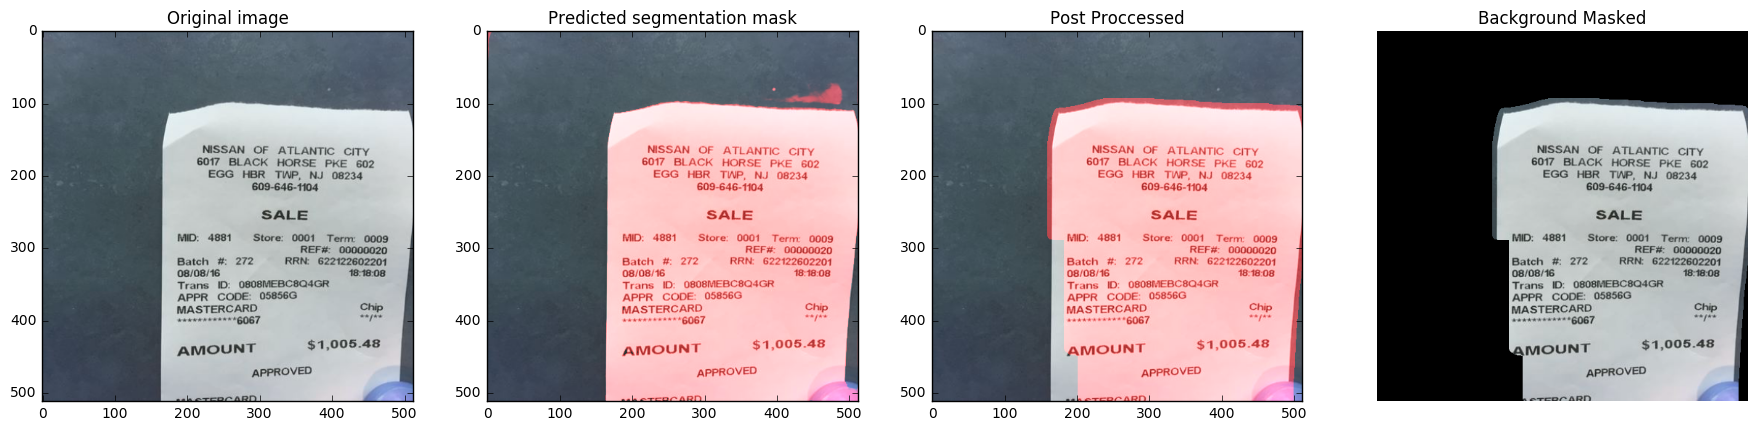

./testImages/32.jpg


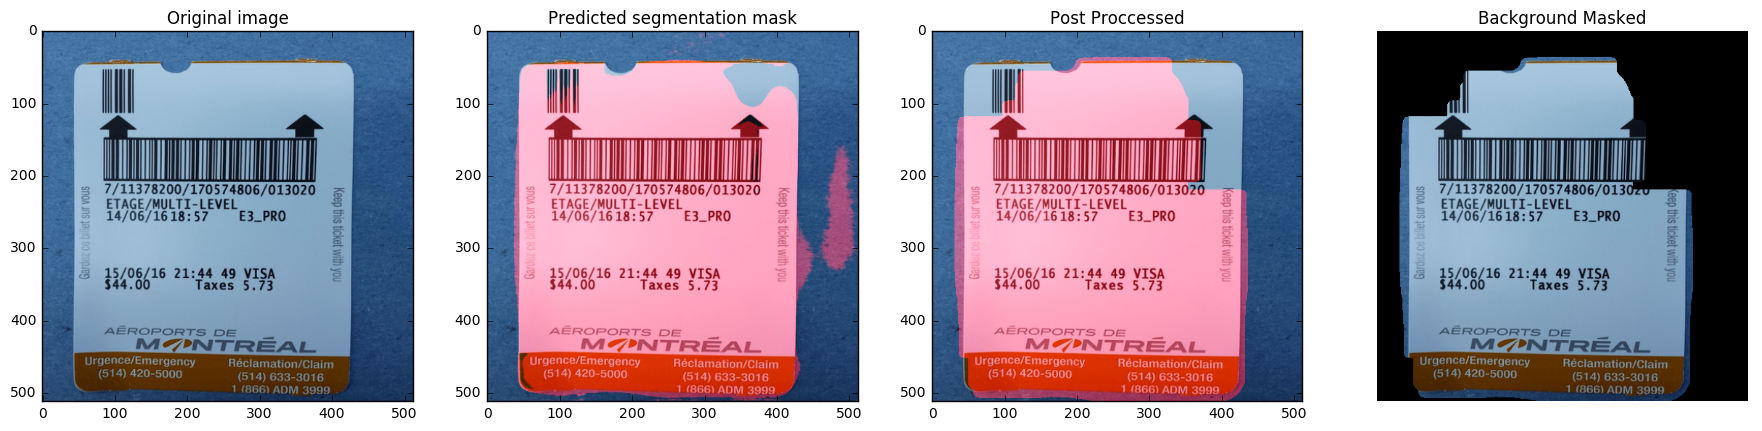

./testImages/41.jpg


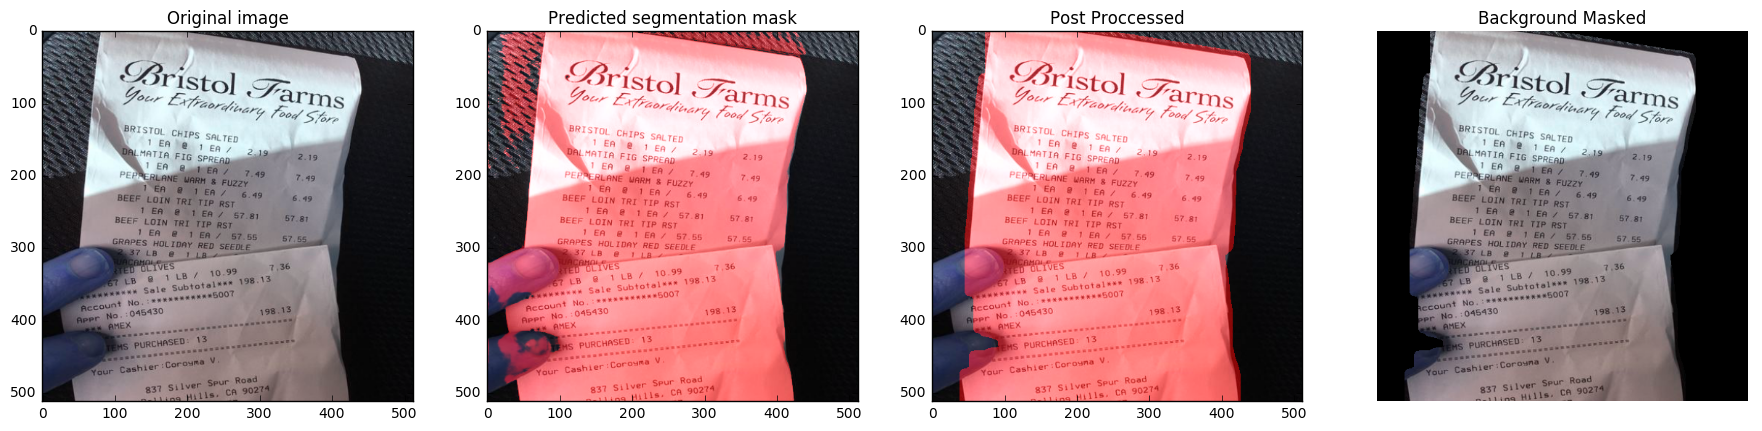

./testImages/118.jpg


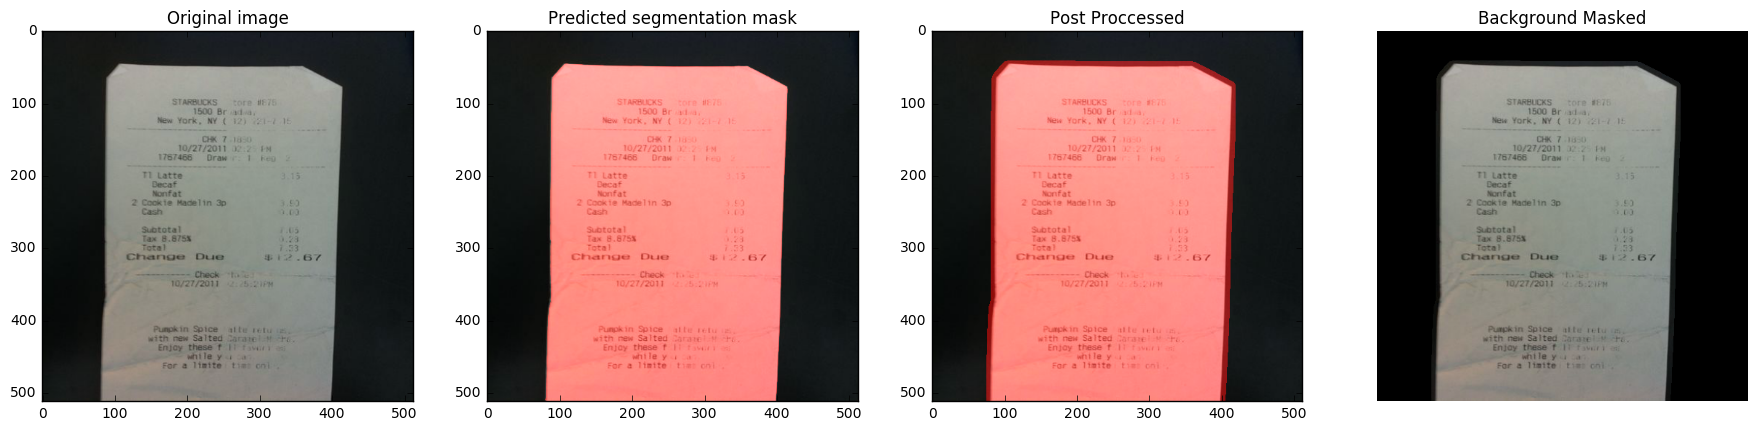

./testImages/125.jpg


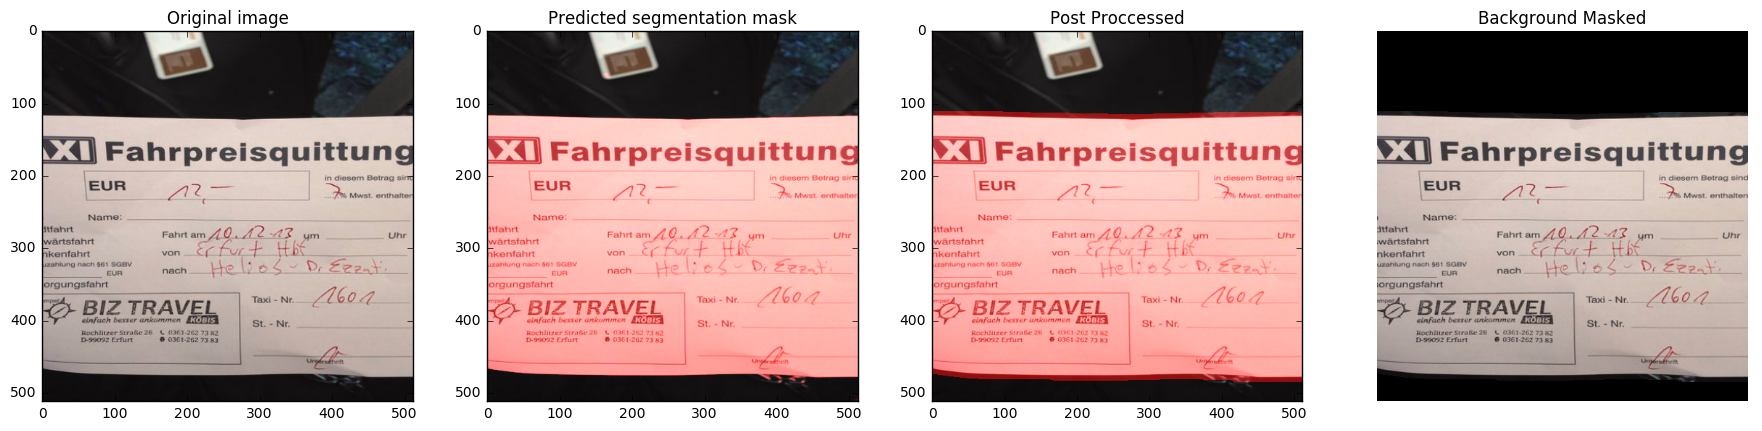

In [90]:
images = glob.glob("./testImages/*.JPG")

for i in range(5):
    
    indx = np.random.randint(len(images)) + 1
    frame = "./testImages/"+str(indx)+".jpg"
        
    print(frame)

    image = cv2.imread(frame)    

    image = cv2.resize(image, (imgCol,imgRow))    
    
    img = image
    xy_array = np.asarray(img)
    xy_array = np.reshape(xy_array,(1,img.shape[0],img.shape[1],3))

    img = model.predict(xy_array)
    

    im = np.array(xy_array[0],dtype=np.uint8)
    im_pred = np.array(255*img[0],dtype=np.uint8)

    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,1,0)
    
    
    #plt.show()
    
    
    kernel = np.ones((15,15),np.uint8)
    erosion = cv2.erode(img[0],kernel,iterations = 5)
    dilation = cv2.dilate(erosion,kernel,iterations = 5)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    dilation = cv2.dilate(dilation,kernel,iterations = 1)
    
    
    dilation = floodFill(dilation)
    dilation = np.reshape(dilation,img[0].shape)
    dilation = np.array(255*dilation,dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(dilation,cv2.COLOR_GRAY2RGB).astype(np.uint8)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]   
    postProcessedImg = cv2.addWeighted(rgb_mask_pred,0.5,im,1,0)
    maskedBack = im.copy()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            flag = True;
            for k in range(im.shape[2]):
                if rgb_mask_pred[i][j][k] != 0:
                    flag = False
            if flag is True:                
                maskedBack[i][j][0] = maskedBack[i][j][1] = maskedBack[i][j][2] = 0
                        
    
    plt.figure(figsize=(22,16))
    plt.subplot(1,4,1)
    plt.imshow(im)
    plt.title('Original image')
    
    plt.subplot(1,4,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    
    plt.subplot(1,4,3)        
    plt.imshow(postProcessedImg)
    plt.title('Post Proccessed')
    
    plt.subplot(1,4,4)        
    plt.imshow(maskedBack)
    plt.title('Background Masked')
    
    plt.axis('off')
    plt.show()
    

./Images\1.JPG


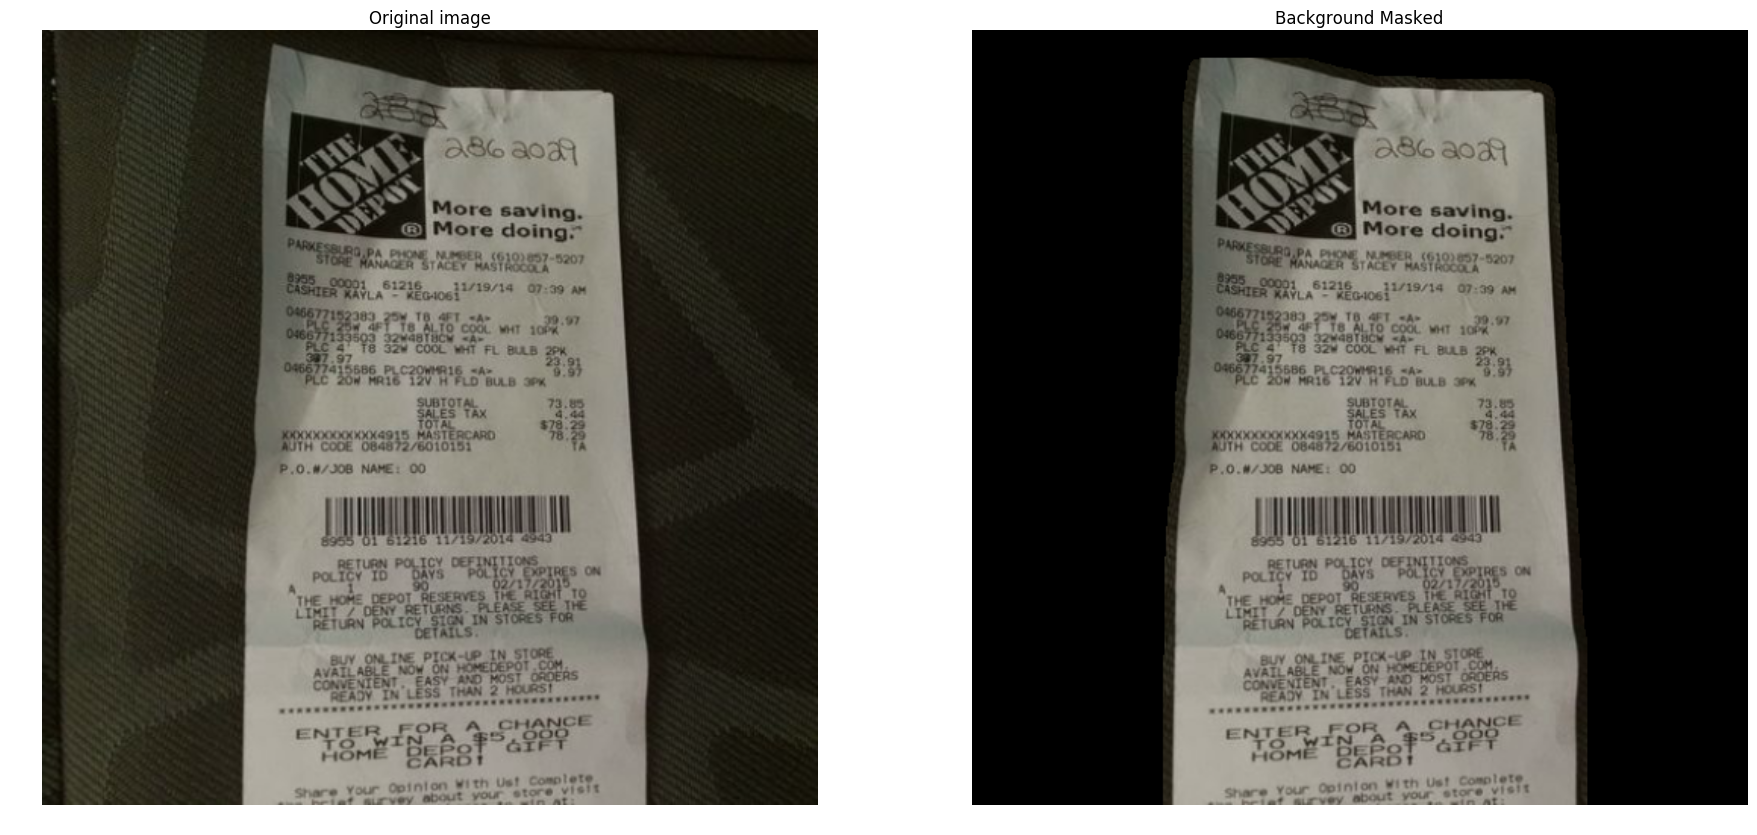

./Images\10.JPG


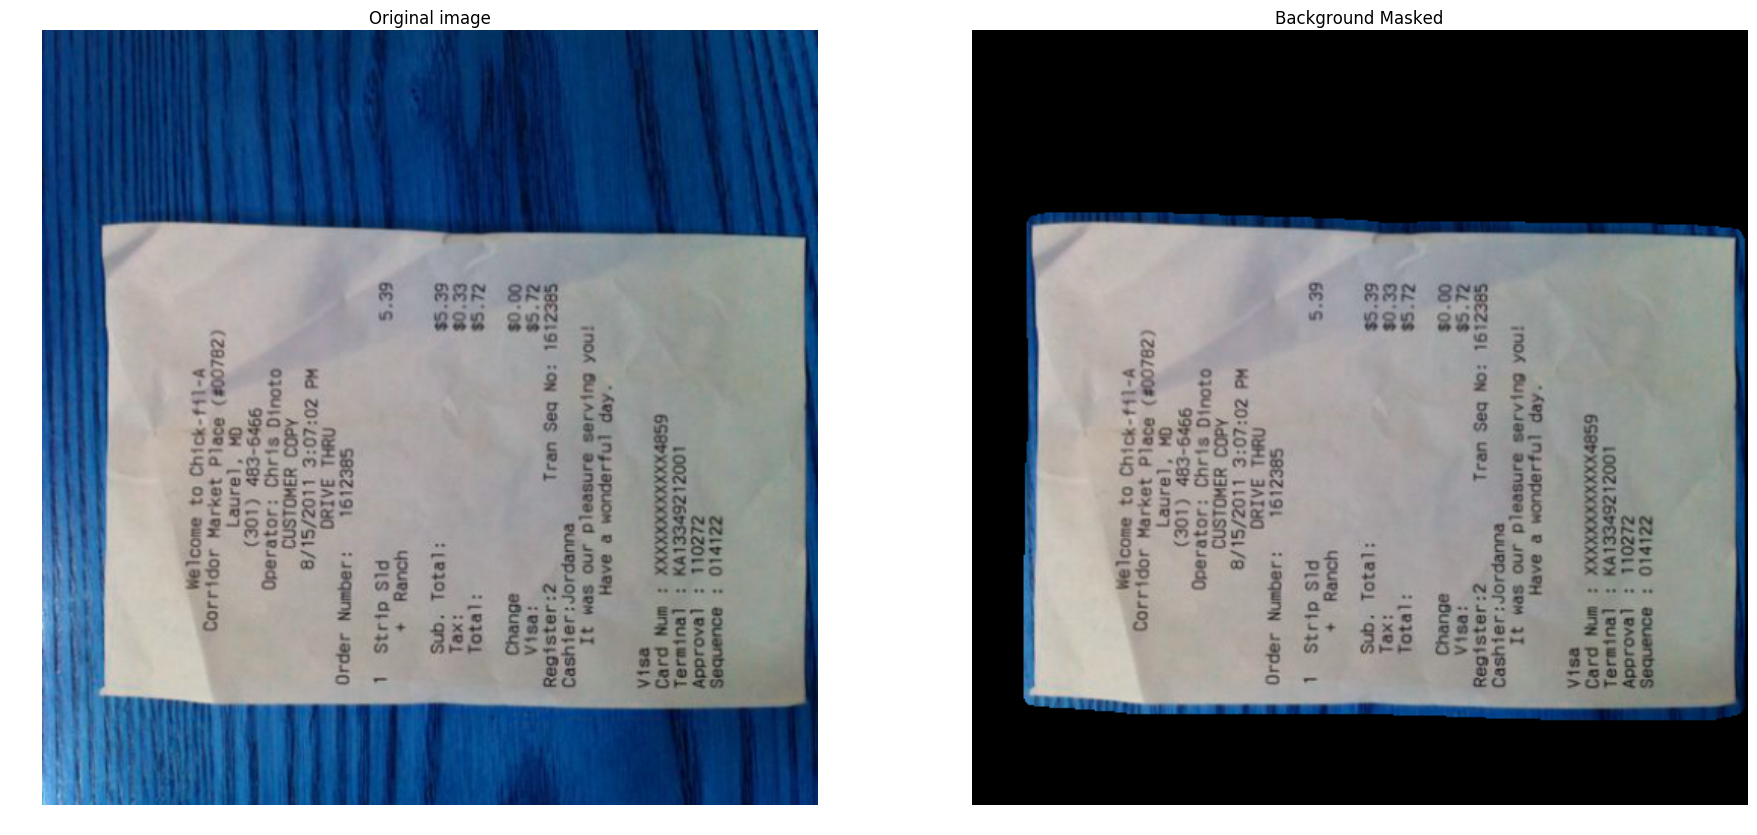

./Images\11.JPG


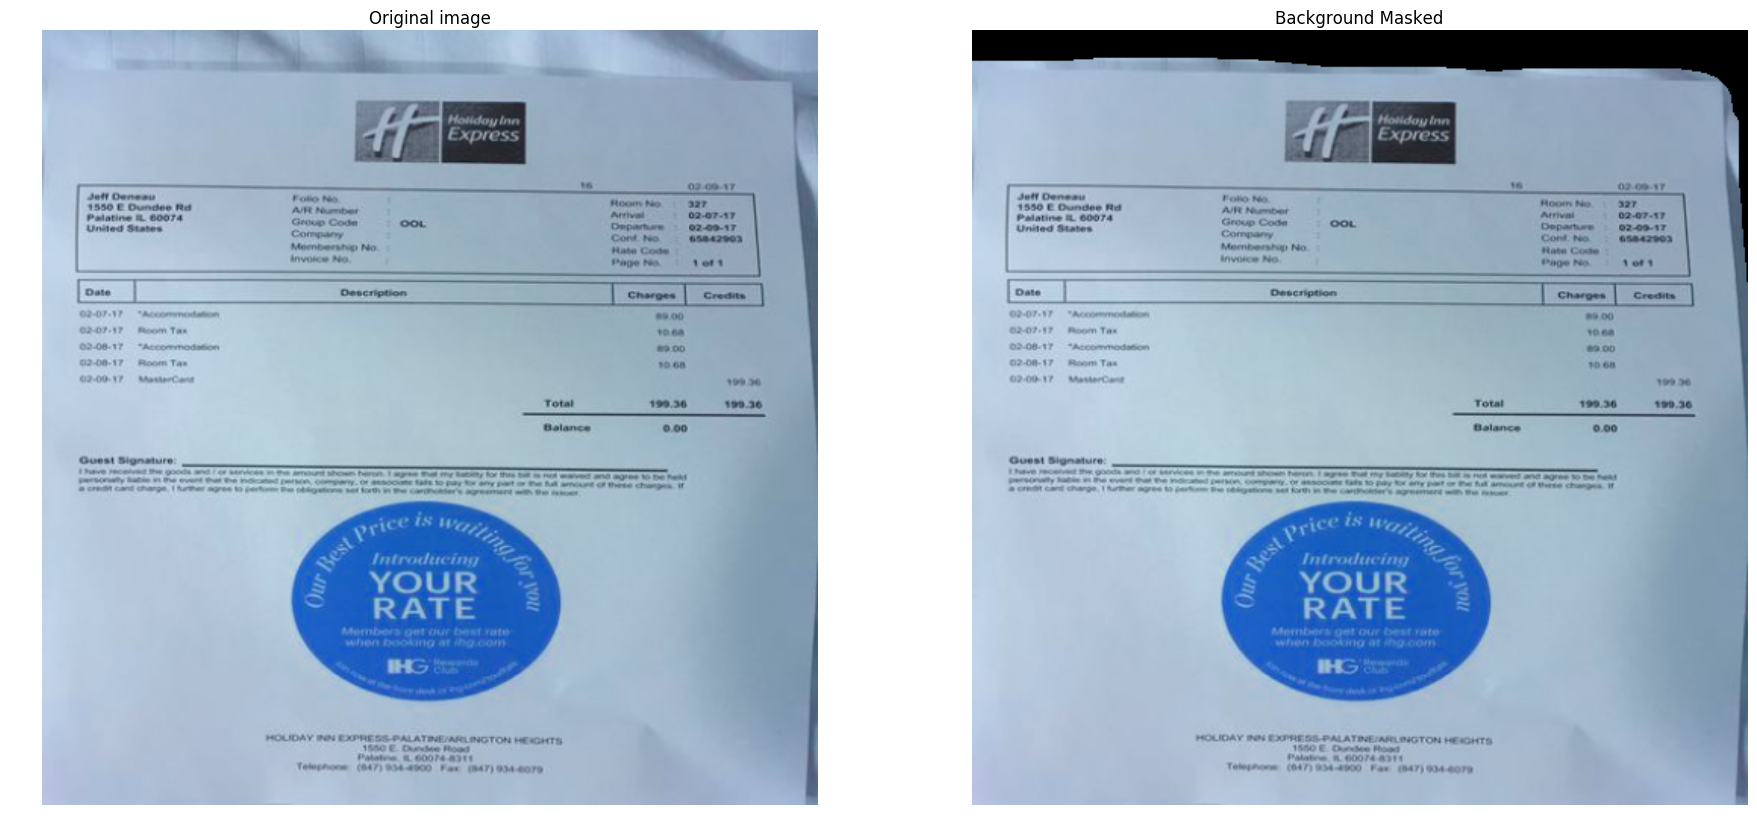

./Images\12.JPG


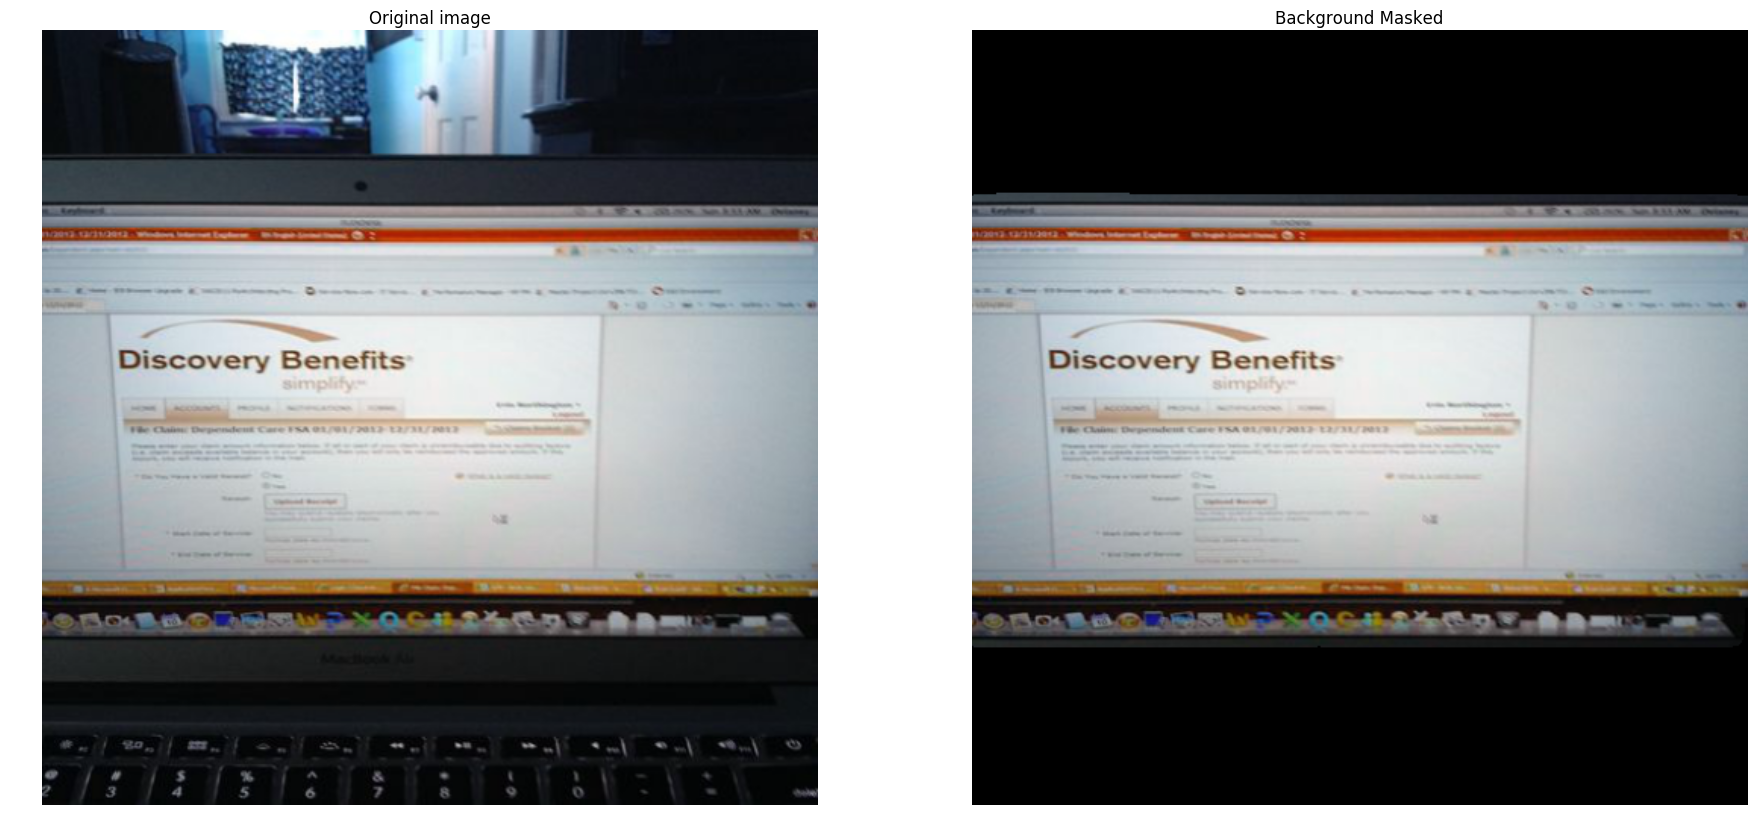

./Images\13.JPG


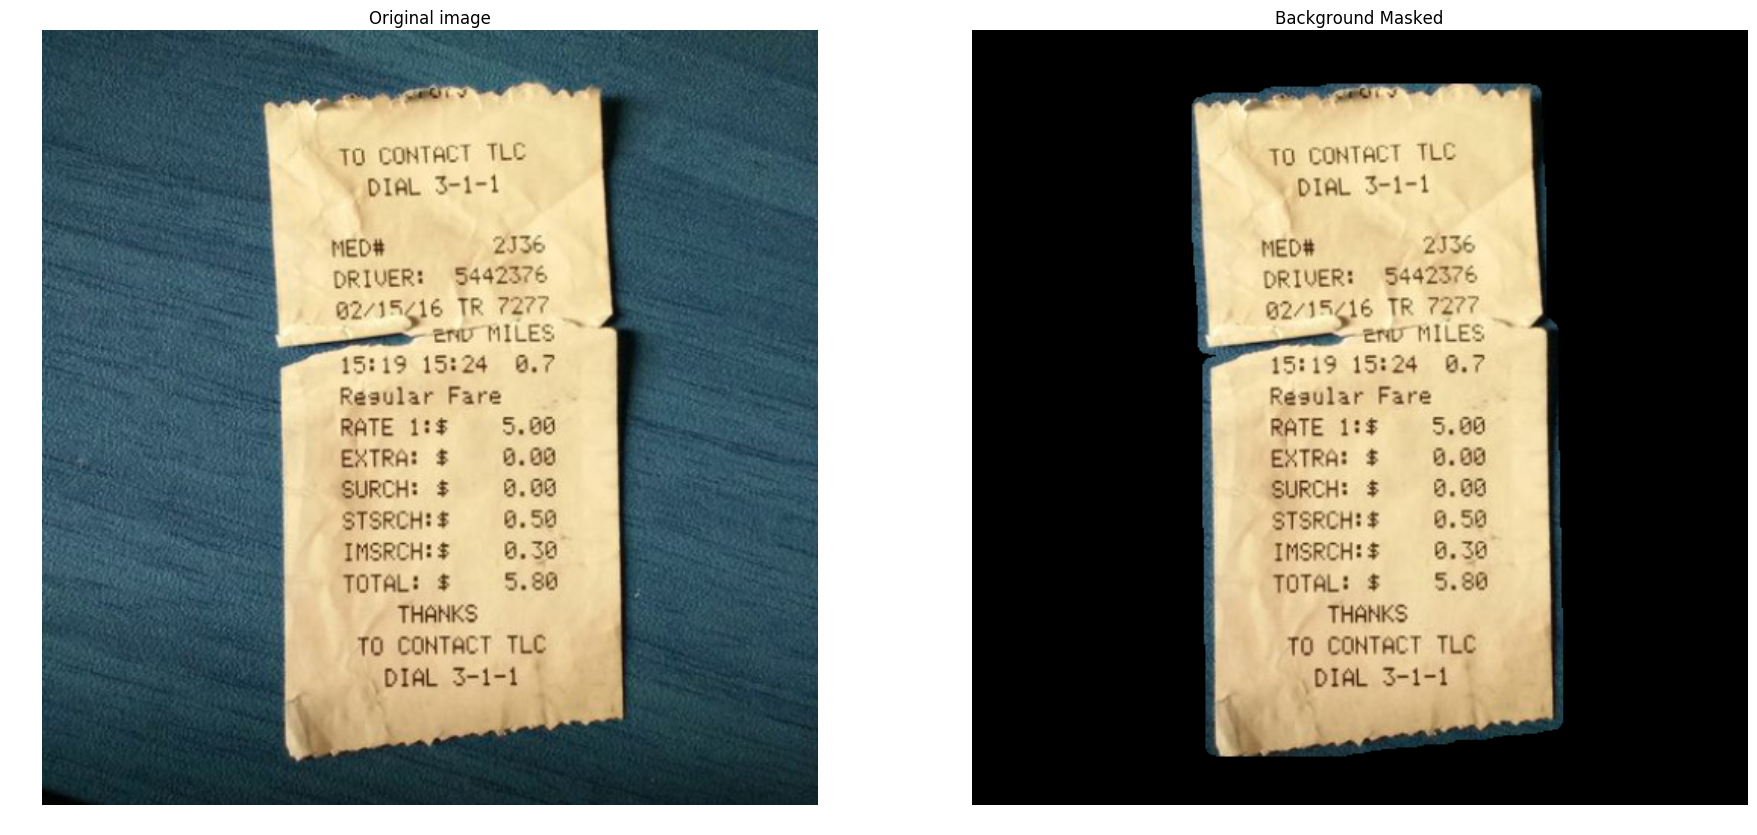

./Images\14.JPG


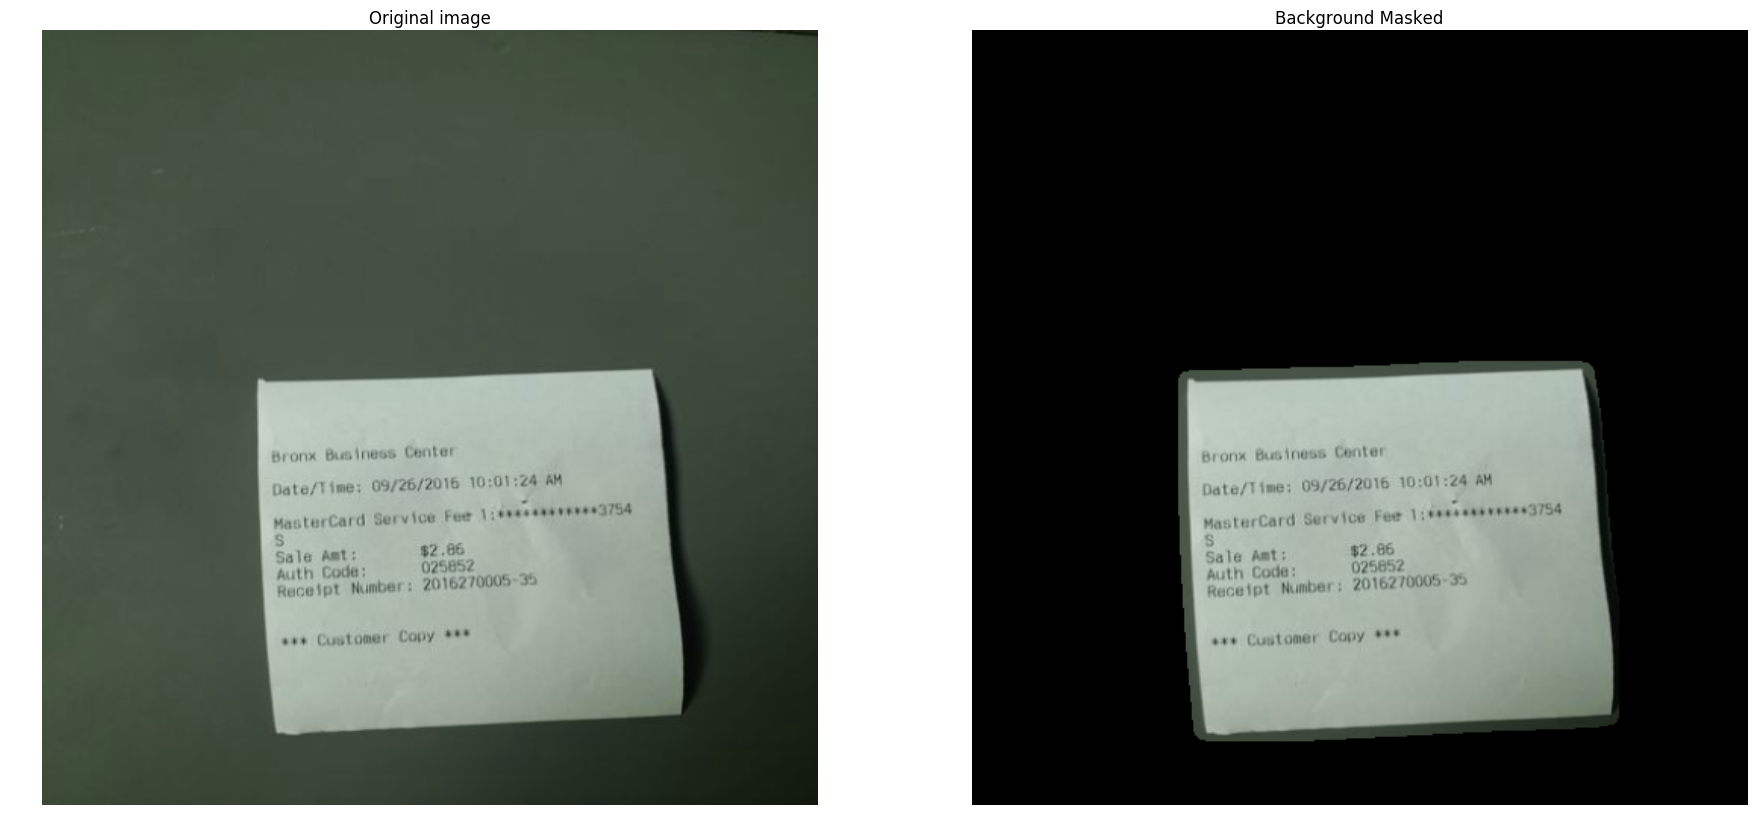

./Images\15.JPG


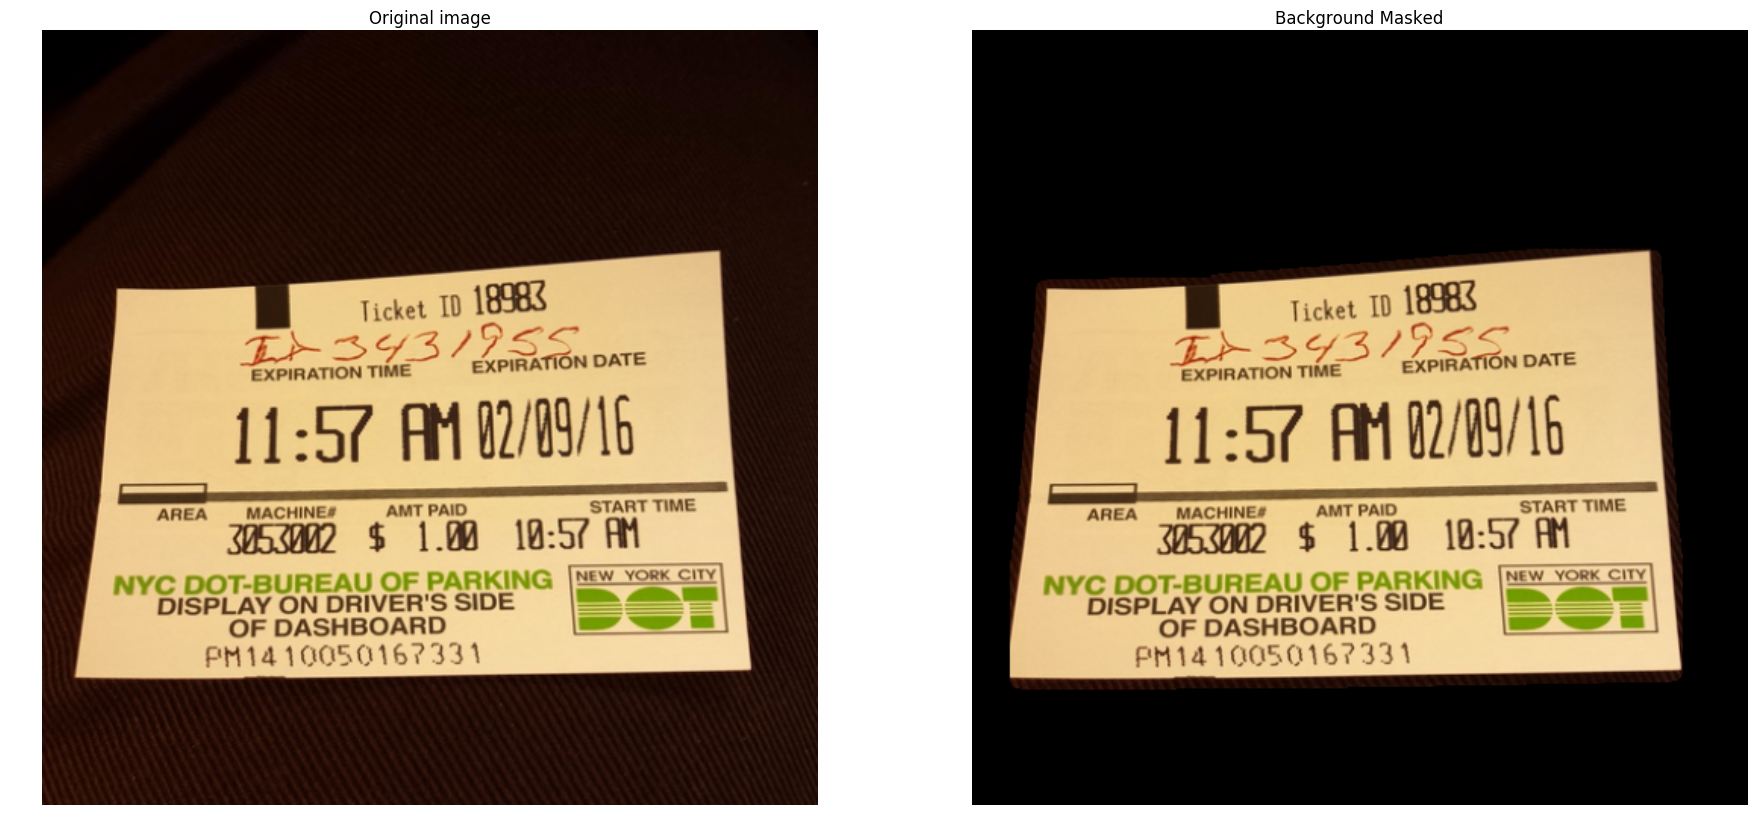

In [96]:
images = glob.glob("./Images/*.JPG")

for indx,frame in enumerate(images):
    
    print(frame)

    image = cv2.imread(frame)    

    image = cv2.resize(image, (imgCol,imgRow))    
    
    img = image
    xy_array = np.asarray(img)
    xy_array = np.reshape(xy_array,(1,img.shape[0],img.shape[1],3))

    img = model.predict(xy_array)
    

    im = np.array(xy_array[0],dtype=np.uint8)
    im_pred = np.array(255*img[0],dtype=np.uint8)

    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,1,0)
    
    
    #plt.show()
    
    
    kernel = np.ones((15,15),np.uint8)
    erosion = cv2.erode(img[0],kernel,iterations = 5)
    dilation = cv2.dilate(erosion,kernel,iterations = 5)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    dilation = cv2.dilate(dilation,kernel,iterations = 1)
    
    
    dilation = floodFill(dilation)
    dilation = np.reshape(dilation,img[0].shape)
    dilation = np.array(255*dilation,dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(dilation,cv2.COLOR_GRAY2RGB).astype(np.uint8)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]   
    postProcessedImg = cv2.addWeighted(rgb_mask_pred,0.5,im,1,0)
    maskedBack = im.copy()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            flag = True;
            for k in range(im.shape[2]):
                if rgb_mask_pred[i][j][k] != 0:
                    flag = False
            if flag is True:                
                maskedBack[i][j][0] = maskedBack[i][j][1] = maskedBack[i][j][2] = 0
                        
    
    plt.figure(figsize=(22,16))
    plt.subplot(1,2,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')    
    
    plt.subplot(1,2,2)        
    plt.imshow(maskedBack)
    plt.title('Background Masked')    
    plt.axis('off')
    
    plt.show()
    if indx > 5:
        break